In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from timeseries import *
from models import *
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.distributed import *
import neptune
from neptunecontrib.monitoring.fastai import NeptuneMonitor
import seaborn as sns
sns.set(style="darkgrid")

/opt/anaconda/envs/pytorch/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [3]:
x, y = pickle.load(open("data/train.pkl", "rb"))
test_name, x_test = pickle.load(open("data/test.pkl", "rb"))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42123456)
x.mean(), x.std(), x.min(), x.max()

(-6.63823368281504e-06, 79.22496224741775, -5831.451171875, 6120.92822265625)

# ICA

In [4]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=2, random_state=0)
x_train_ica = np.array([transformer.fit_transform(ts) for ts in x_train])
x_val_ica = np.array([transformer.fit_transform(ts) for ts in x_val])

In [5]:
x_train_ica.shape

(512, 12, 2)

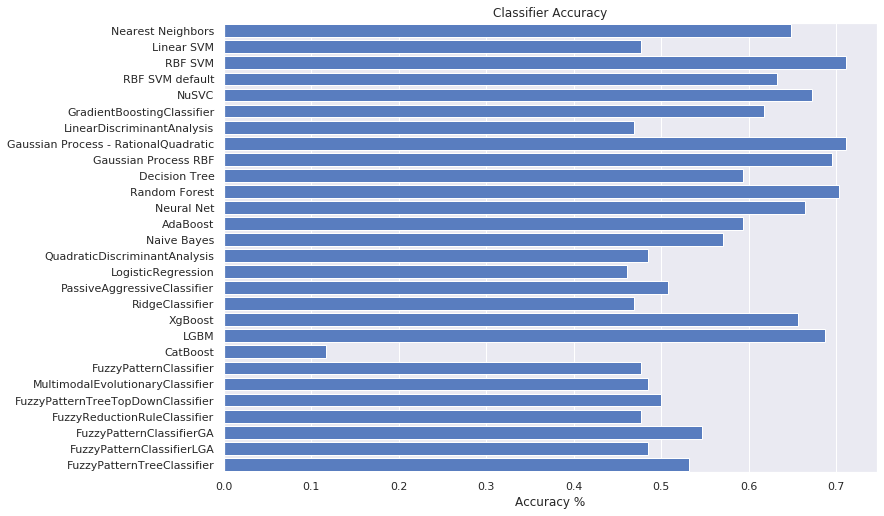

In [16]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from catboost import CatBoostClassifier
from fylearn.nfpc import FuzzyPatternClassifier
from fylearn.garules import MultimodalEvolutionaryClassifier,  EnsembleMultimodalEvolutionaryClassifier
from fylearn.fpt import FuzzyPatternTreeTopDownClassifier
from fylearn.frr import FuzzyReductionRuleClassifier #-- based on learning membership functions from min/max.
from fylearn.fpcga import FuzzyPatternClassifierGA #-- optimizes membership functions globally.
from fylearn.fpcga import FuzzyPatternClassifierLGA,  SEFuzzyPatternClassifier #-- optimizes membership functions locally.
from fylearn.fpt import FuzzyPatternTreeClassifier #-- builds fuzzy pattern trees using bottom-up method.


def test(x_train, y_train, x_val, y_val):
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "RBF SVM default",  "NuSVC", "GradientBoostingClassifier", "LinearDiscriminantAnalysis", "Gaussian Process - RationalQuadratic", "Gaussian Process RBF",
             "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
             "Naive Bayes", "QuadraticDiscriminantAnalysis", "LogisticRegression", 
             "PassiveAggressiveClassifier", "RidgeClassifier"]

    classifiers = [
        KNeighborsClassifier(),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        SVC(),
        NuSVC(probability=True),
        GradientBoostingClassifier(),
        LinearDiscriminantAnalysis(),
        GaussianProcessClassifier(1.0 * RationalQuadratic()),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=1000),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        LogisticRegression(),
        PassiveAggressiveClassifier(),
        RidgeClassifier()
    ]

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_val = sc.fit_transform(x_val)
    # iterate over classifiers
    scores = {}
    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        score = clf.score(x_val, y_val)
        scores[name] = score
#         print(f"{name} {score}")
        
    # fit model no training data
    model = XGBClassifier()
    eval_set = [(x_val, y_val)]
    model.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=eval_set, verbose=False)
    # make predictions for test data
    y_pred = model.predict(x_val)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    score = accuracy_score(y_val, predictions)
#     print(f"XgBoost {score}")
    scores["XgBoost"] = score
    
    lightmodel = LGBMClassifier()
    lightmodel.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=eval_set, verbose=False)
    y_pred = lightmodel.predict(x_val)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    score = accuracy_score(y_val, predictions)
#     print(f"LGBM {score}")
    scores["LGBM"] = score
    
    
    eval_set = [(x_val, y_val-1)]
    catmodel = CatBoostClassifier()
    catmodel.fit(x_train, y_train-1, early_stopping_rounds=100, eval_set=eval_set, verbose=False)
    y_pred = catmodel.predict(x_val)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    score = accuracy_score(y_val, predictions)
#     print(f"CatBoost {score}")
    scores["CatBoost"] = score
    
    fuzzy = [FuzzyPatternClassifier(), MultimodalEvolutionaryClassifier(),FuzzyPatternTreeTopDownClassifier(), FuzzyReductionRuleClassifier(),
             FuzzyPatternClassifierGA(),  
#              EnsembleMultimodalEvolutionaryClassifier().
             FuzzyPatternClassifierLGA(),  
#              SEFuzzyPatternClassifier(),
             FuzzyPatternTreeClassifier() ]
    for f in fuzzy:
        f.fit(x_train, y_train)
        y_pred = f.predict(x_val)
        predictions = [round(value) for value in y_pred]
        scores[f.__class__.__name__] = accuracy_score(y_val, predictions)
    
    # Plot result
    sns.set_color_codes("muted")
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(x=[v for k,v in scores.items()], y=[k for k,v in scores.items()], color="b")
    plt.xlabel('Accuracy %')
    plt.title('Classifier Accuracy')
    plt.show()
#     return scores

test(x_train_ica.reshape(x_train_ica.shape[0],-1), y_train, x_val_ica.reshape(x_val_ica.shape[0], -1), y_val)

# 256 windowed  FFT

In [22]:
from scipy.fft import fft, ifft, rfft
from scipy import signal

In [23]:
def window_stack(a, stepsize=1, width=3):
    return np.array([a[i*stepsize:(i+1)*stepsize] for i in range(0, width)])

In [24]:
x_train_256_window = np.array([[window_stack(i, stepsize=256, width=4096//256) for i in x] for x in x_train])
x_val_256_window = np.array([[window_stack(i, stepsize=256, width=4096//256) for i in x] for x in x_val])

In [25]:
x_train_256_window.shape

(512, 12, 16, 256)

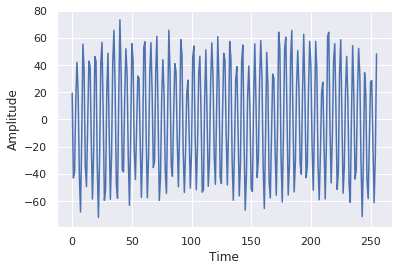

In [26]:
plt.plot(x_train_256_window[0,0,0])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

In [27]:
x_train_256_window_fft = fft(x_train_256_window, n=256)
x_val_256_window_fft = fft(x_val_256_window, n=256)

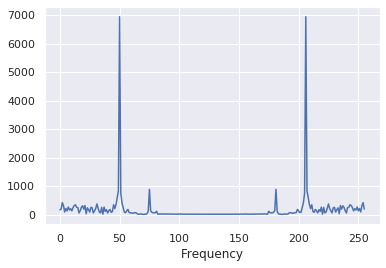

In [28]:
plt.plot(np.abs(x_train_256_window_fft[0,0,0]))
plt.xlabel("Frequency")
plt.show()

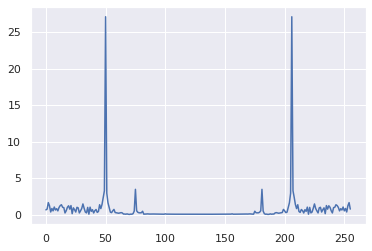

In [29]:
plt.plot(np.abs(x_train_256_window_fft[0,0,0]/len(x_train_256_window_fft[0,0,0])))
plt.show()
Fs = 512;                       
T = 1/Fs;   

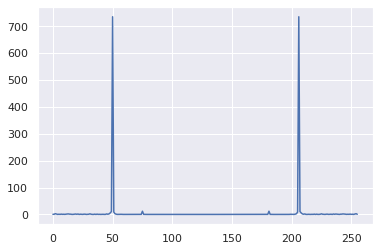

In [30]:
# Energy
plt.plot(np.abs(x_train_256_window_fft[0,0,0]/len(x_train_256_window_fft[0,0,0]))**2)
plt.show()

In [31]:
x_train_256_window_dft = np.abs(x_train_256_window_fft / len(x_train_256_window_fft[0,0,0]))
x_val_256_window_dft =  np.abs(x_val_256_window_fft / len(x_val_256_window_fft[0,0,0]))

In [32]:
x_train_256_window_dft_2 = x_train_256_window_dft**2
x_val_256_window_dft_2 = x_val_256_window_dft**2

In [33]:
x_train_256_window_dft_2.shape

(512, 12, 16, 256)

In [34]:
x_train_reshaped = x_train_256_window_dft_2.reshape(x_train_256_window_dft_2.shape[0], -1)
x_val_reshaped = x_val_256_window_dft_2.reshape(x_val_256_window_dft_2.shape[0], -1)

## Energy

In [ ]:
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

## FFT Result

In [ ]:
x_train_reshaped = x_train_256_window_dft.reshape(x_train_256_window_dft.shape[0], -1)
x_val_reshaped = x_val_256_window_dft.reshape(x_val_256_window_dft.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

# 256 Point fft

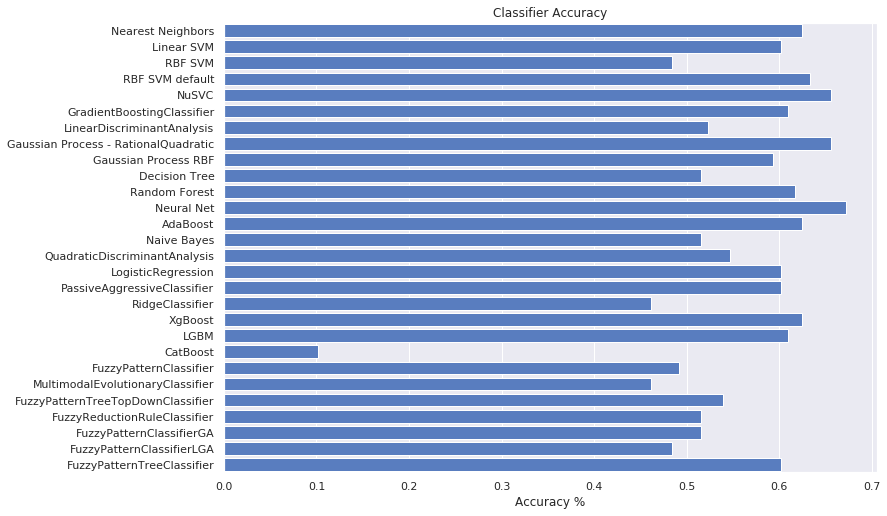

In [20]:
x_train_256_fft = np.abs(fft(x_train, n=256))
x_val_256_fft = np.abs(fft(x_val, n=256))

x_train_reshaped = x_train_256_fft.reshape(x_train_256_fft.shape[0], -1)
x_val_reshaped = x_val_256_fft.reshape(x_val_256_fft.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

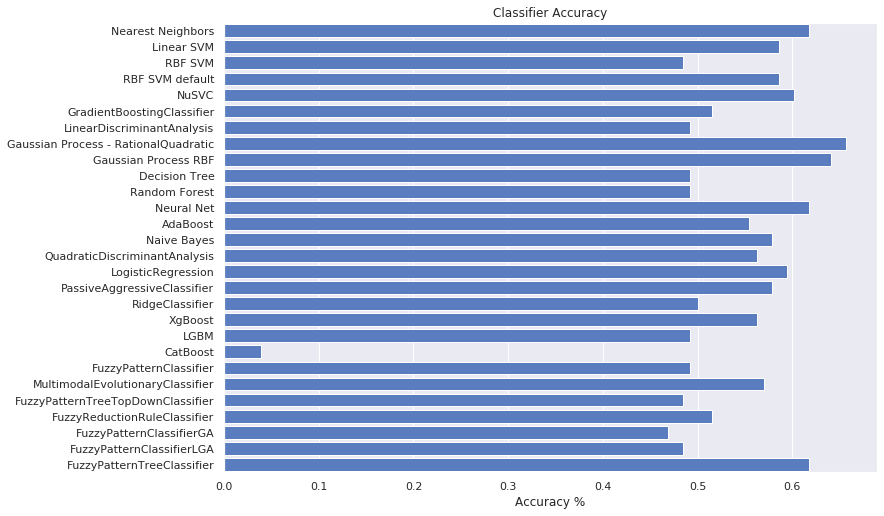

In [21]:
x_train_256_fft_p = np.abs(fft(x_train, n=256))**2
x_val_256_fft_p = np.abs(fft(x_val, n=256))**2

x_train_reshaped = x_train_256_fft_p.reshape(x_train_256_fft_p.shape[0], -1)
x_val_reshaped = x_val_256_fft_p.reshape(x_val_256_fft_p.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

In [ ]:
x_train_256_fft_p = np.abs(fft(x_train, n=256))**2
x_val_256_fft_p = np.abs(fft(x_val, n=256))**2

x_train_reshaped = x_train_256_fft_p.reshape(x_train_256_fft_p.shape[0], -1)
x_val_reshaped = x_val_256_fft_p.reshape(x_val_256_fft_p.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

# FFT 

In [ ]:
x_train_fft = np.abs(fft(x_train))
x_val_fft = np.abs(fft(x_val))

x_train_reshaped = x_train_fft.reshape(x_train_fft.shape[0], -1)
x_val_reshaped = x_val_fft.reshape(x_val_fft.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

In [ ]:
x_train_fft_n = np.abs(fft(x_train))**2
x_val_fft_n = np.abs(fft(x_val))**2

x_train_reshaped = x_train_fft_n.reshape(x_train_fft_n.shape[0], -1)
x_val_reshaped = x_val_fft_n.reshape(x_val_fft_n.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)

# Raw Result

In [ ]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_val_reshaped = x_val.reshape(x_val.shape[0], -1)
test(x_train_reshaped, y_train, x_val_reshaped, y_val)